# Collaboration and Competition

The objective of this project is to train agents to play tennis in the Unity ML-Agents Tennis environment.

## 1. Starting the Environment
We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
from collections import deque
import numpy as np
from config import Config
config = Config()

**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name=config.environment_path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examining the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


#### Updating configuration 
Based on values found we can update our configuration.

In [5]:
config.num_agents = num_agents
config.action_size = action_size
config.state_size = state_size

## 4. Training the agents

### 4.1 . Algorithm
To solve this problem, the Deep Deterministic Policy Gradient will be used. DDPG adapts the ideas of Deep Q-Learning to the continuous action domain. The actor network approximates the optimal policy deterministically (best believed action). The critic evaluates the optimal action value function using the best believed action given by the actor network. DDPG also uses a repĺay buffer where experience tuples are stored.

From [Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971v5) we can find a description of the algorithm:


<img src="./doc/ddpg.png" alt="Drawing" width="700"/>

### 4.2 . Network and Parameters 
Here both the critic newtork and the actor network have two hidden layers with 512 and 256 nodes respectively.

Actor network maps states to actions: 

<img src="./doc/actor.png" alt="Drawing" width="700"/>

The critic network maps (state, action) pairs to Q values: 

<img src="./doc/critic.png" alt="Drawing" width="700"/>


The parameters used were:
    
| Parameter Description|  Variable  | Value |
|-----------|------------|------|
|Size of the replay buffer D|BUFFER_SIZE|1e6|
|Mini-batch size|BATCH_SIZE|512|
|Discount factor|GAMMA|0.99|
|$\\tau$ for soft update of target parameters|TAU|1e-3|
|Actor learning rate|LR|3e-4|
|Actor learning rate|LR|5e-4|
|L2 weight decay|WEIGHT_DECAY|0.0|

When training the environment, we need to set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
from agent import Agent
from replay import ReplayBuffer 
import torch

agents = [Agent(config) for _ in range(config.num_agents)]
memory = ReplayBuffer(config.action_size, config.buffer_size, config.batch_size, config.random_seed)

In [7]:
def ddpg(n_episodes=3000, max_steps=2000, shared=True):
    scores_global = []
    moving_scores = deque(maxlen=100)
    timestep = 0
    
    for i_episode in range(1, n_episodes+1):
        
        ## Reset all agents
        for agent in agents:
            agent.reset()
            
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations           
        scores = np.zeros(num_agents)

        for i in range(max_steps):
            # Each agent takes its action
            actions = [agent.act(np.expand_dims(state, axis=0))
               for agent, state in zip(agents, states)]
            
            # Retrieving information from interaction with environment
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            dones = env_info.local_done

            # Adding experience tuples to the shared buffer
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                memory.add(state, action, reward, next_state, done)

            # Learn every update_every time steps.
            timestep = (timestep + 1) % config.update_every
            if timestep == 0:
              # If enough samples are available in memory, get random subset and learn
              if len(memory) > config.batch_size:
                for agent in agents:
                    if shared:
                        experiences = memory.sample()
                    else:
                        experiences = agent.memory.sample()
                    agent.learn(experiences, config.gamma)

            scores += rewards
            states = next_states
                
        # max of the agents scores
        current_score = np.max(scores)
        moving_scores.append(current_score)
        scores_global.append(current_score)
        
        print('\rEpisode {} \t Current score: {:.4f}  \tAverage Score: {:.4f}' \
              .format(i_episode, current_score, np.mean(moving_scores)), end="")
        
        # Print every 10 episodes
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(moving_scores)))
        
        # Environment solved after average of +0.5 is reached and after 100 episodes
        if np.mean(moving_scores) >= 0.5 and len(moving_scores) >= 100:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(moving_scores)))
            torch.save(agents[0].actor_local.state_dict(), './data/checkpoint_actor.pth')
            torch.save(agents[0].critic_local.state_dict(), './data/checkpoint_critic.pth')
            break 
            
    return scores_global

In [8]:
scores = ddpg()

/home/lgos/anaconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 10	Average Score: -0.55
Episode 20	Average Score: -0.59
Episode 30	Average Score: -0.11
Episode 40	Average Score: 0.59
Episode 50	Average Score: 1.10
Episode 60	Average Score: 1.55
Episode 70	Average Score: 1.82
Episode 80	Average Score: 2.01
Episode 90	Average Score: 2.09
Episode 100	Average Score: 2.11

Environment solved in 100 episodes!	Average Score: 2.11


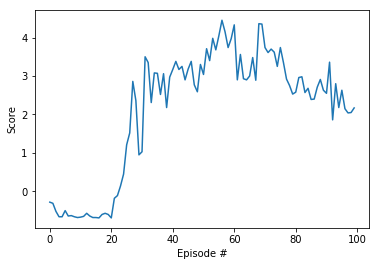

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, we can close the environment.

In [10]:
env.close()

## 5. Ideas for future work
To improve the agents performance some possible options are:
- Test algorithms like PPO, A3C or D4PG 
- Changing network architecture, hyperparameters or size.
- Grid search to find optimal hyperparameters
- Test individual replay buffer for each agent